## Importing necessary packages

In [1]:
import pandas as pd
import numpy as np
import nltk

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.porter import *
np.random.seed(2018)
nltk.download('wordnet')

%matplotlib inline
import matplotlib.pyplot as plt

[nltk_data] Downloading package wordnet to /Users/ayyoki/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
my_data = pd.read_csv('winemag-data-130k-v2.csv', error_bad_lines=False)

In [20]:
#extracting the description portion of the data(where most of the text info is)
description = my_data[['description']]
description['index'] = description.index

/Users/ayyoki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
description.head(5)

,description,index
0,"Aromas include tropical fruit, broom, brimston...",0
1,"This is ripe and fruity, a wine that is smooth...",1
2,"Tart and snappy, the flavors of lime flesh and...",2
3,"Pineapple rind, lemon pith and orange blossom ...",3
4,"Much like the regular bottling from 2012, this...",4


In [6]:
###calculate the missing portion of the data
total_na = my_data.isnull().sum()
percent_missing = (my_data.isnull().sum()/my_data.isnull().count()*100)
missing_data  = pd.concat([total_na, percent_missing], axis=1, keys=['total_na', 'percent_missing'])
missing_data

,total_na,percent_missing
Unnamed: 0,0,0.000000
country,63,0.048472
description,0,0.000000
designation,37465,28.825661
points,0,0.000000
price,8996,6.921544
province,63,0.048472
region_1,21247,16.347493
region_2,79460,61.136715
taster_name,26244,20.192197


## The first step I took is writing function that cleans words for me, this includes tokenization, lemmatization, stem, and remove stopwords.

In [12]:
###get the Part-of-speech feature in order to identify what vocabulary(verb,noun,adj or adv)
###This is for Lemmatization to correctly lemmatize words.
from nltk.corpus import wordnet
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [33]:
###this step write a function and perform both lemmatization and stem, as well as 
###tokenization to the imported text using features from ultk and gensim
###my experience from internship told me that lemmatize first then stem 
###providing the best accuracy, note we use POS feature for lemmatization
stemmer = PorterStemmer()
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos=get_wordnet_pos(text)))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) >= 2:
            result.append(lemmatize_stemming(token))
    return result

## Apply Text pre-processing

In [34]:
cleaned_description = description['description'].map(preprocess)


In [39]:
### now, we processed lemmatization and stem to the documents.
## As we can see, reduced in document 12 has been transformed to reduce.
#building has become build.
cleaned_description.head(5)

0    [aroma, includ, tropic, fruit, broom, brimston...
1    [ripe, fruiti, wine, smooth, structur, firm, t...
2    [tart, snappi, flavor, lime, flesh, rind, domi...
3    [pineappl, rind, lemon, pith, orang, blossom, ...
4    [like, regular, bottl, come, rough, tannic, ru...
Name: description, dtype: object

### save the cleaned text data

In [41]:
##add this back to original data.
my_data['cleaned_description'] = cleaned_description
my_data.to_csv('lemma_stem_cleaned_description.csv')

# Catboost Model(gradient boosting with categorical features)

### Next, apply the TF-IDF to the documents, convert it to numeric values that could tell the importance of certain words

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostRegressor, cv
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [9]:
def prepare_dataframe(vect, data, features=True):
    vectorized=vect.fit_transform(data['cleaned_description']).toarray()
    vectorized=pd.DataFrame(vectorized)
    if features == True:
        X=data.drop(columns=['points','Unnamed: 0','description','cleaned_description'])
        X=X.drop(columns = ['Unnamed: 0.1'])
        X=X.fillna(-1)
        print(X.columns)
        X=pd.concat([X.reset_index(drop=True),vectorized.reset_index(drop=True)],axis=1)
        categorical_features_indices =[0,1,3,4,5,6,7,8,9,10]
    else:
        X=vectorized
        categorical_features_indices =[]
    y=data['points']
    return X,y,categorical_features_indices

In [10]:

def perform_model(X_train, y_train,X_valid, y_valid,X_test, y_test,categorical_features_indices,name):
    model = CatBoostRegressor(
        random_seed = 542,
        loss_function = 'RMSE',
        iterations=500,
    )
    
    model.fit(
        X_train, y_train,
        cat_features = categorical_features_indices,
        verbose=False,
        eval_set=(X_valid, y_valid)
    )
    print('RMSE train:', np.sqrt(metrics.mean_squared_error(y_train, model.predict(X_train))))
    print('RMSE valid:', np.sqrt(metrics.mean_squared_error(y_valid, model.predict(X_valid))))
    print('RMSE test:', np.sqrt(metrics.mean_squared_error(y_test, model.predict(X_test))))
    X, y , categorical_features_indices = prepare_dataframe(vect, data,True)
    feature_score = pd.DataFrame(list(zip(X.dtypes.index, model.get_feature_importance(Pool(X, label=y, cat_features=categorical_features_indices)))),
                columns=['Feature','Score'])
    feature_score1 = feature_score[1:10]
    feature_score1.sort_values(by=['Score'])
    ax = feature_score1.plot('Feature', 'Score', kind='bar', color='c')
    ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
    ax.set_xlabel('')

    rects = ax.patches

    labels = feature_score1['Score'].round(2)

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

    plt.show()

    

In [11]:
def prepare_variable(vect, data, append=True):
    X, y , categorical_features_indices = prepare_dataframe(vect, data,append)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, 
                                                        random_state=32)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, 
                                                        random_state=52)
    return X_train, y_train,X_valid, y_valid,X_test, y_test, categorical_features_indices

In [12]:
data = pd.read_csv('lemma_stem_cleaned_description.csv')

Index(['country', 'designation', 'price', 'province', 'region_1', 'region_2',
       'taster_name', 'taster_twitter_handle', 'title', 'variety', 'winery'],
      dtype='object')
RMSE train: 1.6086510858291974
RMSE valid: 1.7016492290070897
RMSE test: 1.7096774871794596


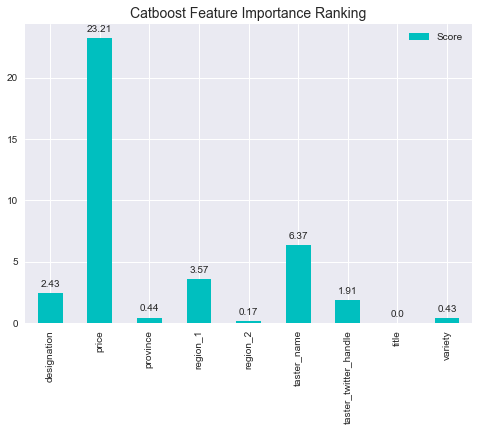

In [313]:
vect= TfidfVectorizer(analyzer='word',max_features=200)
training_variable=prepare_variable(vect, data)
perform_model(*training_variable, 'TF-IDF')

Index(['country', 'designation', 'price', 'province', 'region_1', 'region_2',
       'taster_name', 'taster_twitter_handle', 'title', 'variety', 'winery'],
      dtype='object')
RMSE train: 1.6086510858291974
RMSE valid: 1.7016492290070897
RMSE test: 1.7096774871794596
Index(['country', 'designation', 'price', 'province', 'region_1', 'region_2',
       'taster_name', 'taster_twitter_handle', 'title', 'variety', 'winery'],
      dtype='object')


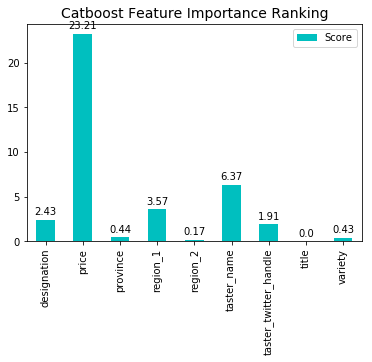

Model Runtime:  142.3175798329994


In [14]:
###let's see the run time
import timeit
start = timeit.default_timer()

vect= TfidfVectorizer(analyzer='word',max_features=200)
training_variable=prepare_variable(vect, data)
perform_model(*training_variable, 'TF-IDF')

stop = timeit.default_timer()
print('Model Runtime: ', stop - start)  


In [247]:
##please note this test_error.tsv comes from 800 iters, because I would
##like to see where the curve turns flat and make a cut there

from pandas import DataFrame
validation_set_error = DataFrame.from_csv("test_error.tsv", sep="\t")
validation_set_error.to_csv('validation_error_per_itr.csv')

/Users/ayyoki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  


In [53]:
validation_error_per_itr=pd.read_csv('validation_error_per_itr.csv')

In [54]:
validation_error_per_itr.tail(5)

,iter,RMSE
795,795,1.638041
796,796,1.637927
797,797,1.637790
798,798,1.637676
799,799,1.637447


Text(0, 0.5, 'RMSE')

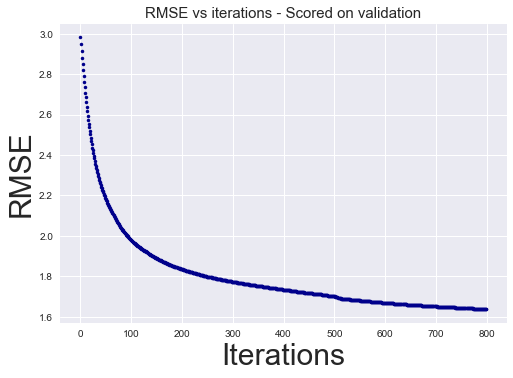

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.plot(validation_error_per_itr['iter'], validation_error_per_itr['RMSE'], '.', color='darkblue',linewidth=2);
plt.title('RMSE vs iterations - Scored on validation',fontsize=15)
plt.xlabel('Iterations',fontsize=30)
plt.ylabel('RMSE',fontsize=30)

#the curve flats out around iter#500, so we will choose 500 iterations to avoid too many iters that lead to overfitting.

# Random Forest Model

In [17]:
vect= TfidfVectorizer(analyzer='word',max_features=200)
X, y , categorical_features_indices = prepare_dataframe(vect, data,True)

Index(['country', 'designation', 'price', 'province', 'region_1', 'region_2',
       'taster_name', 'taster_twitter_handle', 'title', 'variety', 'winery'],
      dtype='object')


### ONE-HOT encoding
- ### Unlike Catboost that handle categorical variables automatically, random forest needs us to encode all categorical variables. I tried to encode all categorical variables including desgination and winery. Which involves too many degree of freedom and that means our dummy matrix will be more than 40,000 columns. As we see the variable improtance from catboost, those are not very important so I chose to drop them. 



In [18]:
new_data = X.drop(['designation', 'winery','region_2','taster_twitter_handle','title'], axis = 1)
dummies = pd.get_dummies(new_data,prefix = ['country', 'province', 'region_1', 'taster_name','variety']) 
# adding 2629 dummy columns to it.
dummies.shape

(129971, 2629)

In [19]:
temp = new_data.drop(['country', 'province', 'region_1', 'taster_name','variety','price'],axis=1)

In [20]:
##merge dummies and tf-idf to move forward
temp = new_data.drop(['country', 'province', 'region_1', 'taster_name','variety','price'],axis = 1)

new_data_dummied_tfidf = pd.concat([temp, dummies],axis = 1)

In [21]:
# Import the random regressor
from sklearn.ensemble import RandomForestRegressor

X = new_data_dummied_tfidf

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                        random_state=542)

#80:20 split, we just use train and validation, no test set this time. 
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', X_test.shape)
print('Testing Features Shape:', y_train.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (103976, 2829)
Training Labels Shape: (25995, 2829)
Testing Features Shape: (103976,)
Testing Labels Shape: (25995,)


In [22]:
import timeit
start = timeit.default_timer()
rf = RandomForestRegressor(random_state = 542)

rf.fit(X_train, y_train)
print('RMSE train:', np.sqrt(metrics.mean_squared_error(y_train, rf.predict(X_train))))
print('RMSE valid:', np.sqrt(metrics.mean_squared_error(y_test, rf.predict(X_test))))

stop = timeit.default_timer()
print('RF Model Runtime: ', stop - start)  

/Users/ayyoki/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RMSE train: 0.7924062035273393
RMSE valid: 1.8522517915675674
RF Model Runtime:  328.46408298999995


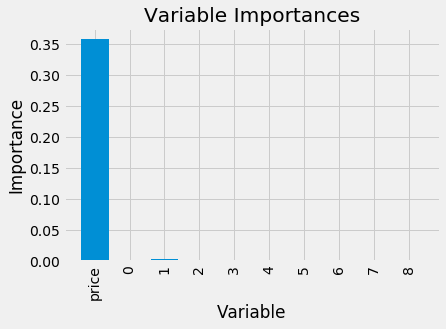

In [45]:
importances = list(rf.feature_importances_)
importances = importances[200:210]
feature_list = list(X.columns)
feature_list = feature_list[200:210]

plt.style.use('fivethirtyeight')
x_values = list(range(len(importances)))

plt.bar(x_values, importances, orientation = 'vertical')

plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

## Let's do more EDA

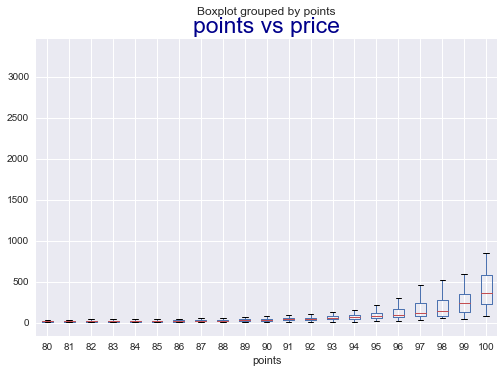

In [161]:
data.boxplot(column='price',by='points')
plt.title("points vs price",fontsize=23, color = 'darkblue')
plt.show() 


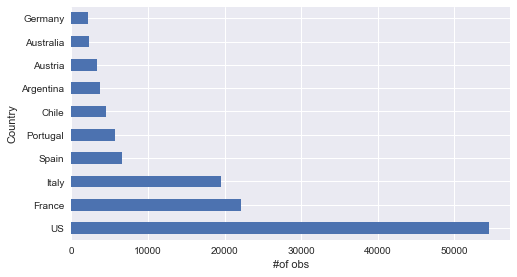

In [59]:
fig, ax = plt.subplots(figsize=(7,4))
country.head(10).plot(kind='barh', legend = False, ax=ax)
ax.set_xlabel('#of obs')
ax.set_ylabel('Country')

plt.show()

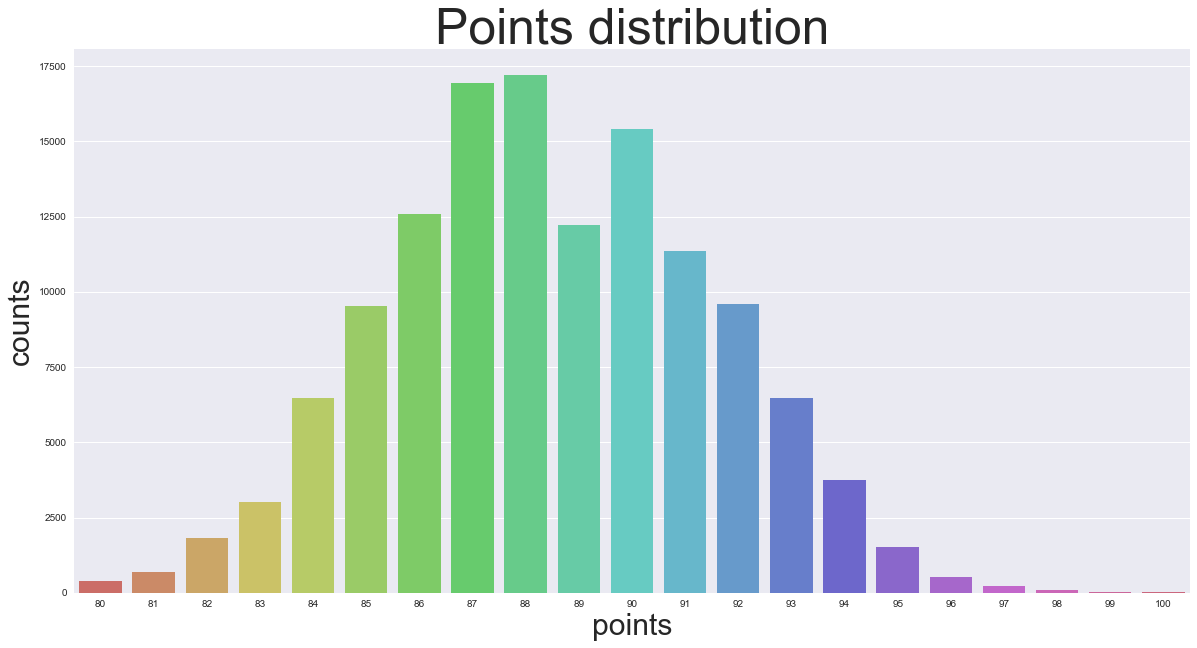

In [52]:
f = plt.figure(figsize=(20,10))
ax = sns.countplot(x='points',data = data, palette='hls' )
ax.set_xlabel('points', fontsize = 30)
ax.axes.set_title("Points distribution",fontsize=50)
ax.set_ylabel('counts', fontsize = 30)
plt.show()

## Now let's start on Question 2

In [25]:
cheap_wine_index = data['price'] < 20
cheap_wine = data[cheap_wine_index]

In [26]:
cheap_wine.shape

(39401, 16)

In [27]:
cheap_fruity_wine_ind = cheap_wine['description'].str.contains('fruit')
cheap_fruity_wine=cheap_wine[cheap_fruity_wine_ind]
cheap_fruity_wine.shape

(20357, 16)

In [28]:
cheap_fruity_wine_pinotnoir_ind = cheap_fruity_wine['variety']=='Pinot Noir'
cheap_fruity_wine_pinotnoir = cheap_fruity_wine[cheap_fruity_wine_pinotnoir_ind]
cheap_fruity_wine_pinotnoir.shape



(550, 16)

In [29]:
cheap_fruity_wine_pinotnoir.sort_values('points', ascending=False)[['winery','points']][1:11]


,winery,points
125857,Stadlmann,93
43930,Stadlmann,93
126313,Tangley Oaks,92
104066,Starmont,92
11094,Schug,92
99597,Meinklang,92
35002,Markowitsch,92
106901,Garnet,92
94207,J. Lohr,92
94850,Louis Max,91


## This section calculate the average points by the top 10 wineries above(that make top 10 best fruity Pinot Noir

In [30]:
####Stadlmann
Stadlmann_ind = data['winery'] == 'Stadlmann'
Stadlmann = data[Stadlmann_ind]
avg_Stadlmann = Stadlmann['points'].mean()

####Tangley_Oaks
Tangley_Oaks_ind = data['winery'] == 'Tangley Oaks'
Tangley_Oaks = data[Tangley_Oaks_ind]
avg_Tangley_Oaks = Tangley_Oaks['points'].mean()

####Starmont
Starmont_ind = data['winery'] == 'Starmont'
Starmont = data[Starmont_ind]
avg_Starmont = Starmont['points'].mean()

####Schug
Schug_ind = data['winery'] == 'Schug'
Schug = data[Schug_ind]
avg_Schug = Schug['points'].mean()

####Meinklang
Meinklang_ind = data['winery'] == 'Meinklang'
Meinklang = data[Meinklang_ind]
avg_Meinklang = Meinklang['points'].mean()

####Markowitsch
Markowitsch_ind = data['winery'] == 'Markowitsch'
Markowitsch = data[Markowitsch_ind]
avg_Markowitsch = Markowitsch['points'].mean()

####Garnet
Garnet_ind = data['winery'] == 'Garnet'
Garnet = data[Garnet_ind]
avg_Garnet = Garnet['points'].mean()

####J. Lohr
JLohr_ind = data['winery'] == 'J. Lohr'
JLohr = data[JLohr_ind]
avg_JLohr = JLohr['points'].mean()

####Louis Max
Louis_Max_ind = data['winery'] == 'Louis Max'
Louis_Max = data[Louis_Max_ind]
avg_Louis_Max = Louis_Max['points'].mean()



In [109]:
general_wine_points = pd.DataFrame({'avg_points_general': [avg_Stadlmann,avg_Tangley_Oaks,avg_Starmont,avg_Schug,avg_Meinklang,avg_Markowitsch,avg_Garnet,avg_JLohr,avg_Louis_Max],
                   'winery_name': ['Stadlmann', 'Tangley_Oaks','Starmont','Schug','Meinklang','Markowitsch','Garnet','J. Lohr','Louis Max'],
                  })

In [107]:
general_wine_points=general_wine_points.sort_values('avg_points_general', ascending=False)




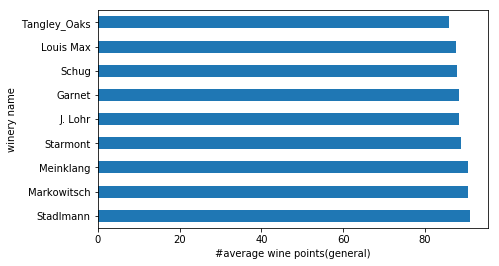

In [33]:
fig, ax = plt.subplots(figsize=(7,4))
general_wine_points.plot(kind='barh', legend = False, ax=ax)
ax.set_xlabel('#average wine points(general)')
ax.set_yticklabels(general_wine_points['winery_name'])
ax.set_ylabel('winery name')

plt.show()

In [34]:
top_n= pd.concat([Stadlmann, Tangley_Oaks,Starmont,Schug,Meinklang,Markowitsch,Garnet,JLohr,Louis_Max],axis = 0)
top_n= top_n.sort_values('points', ascending=False)


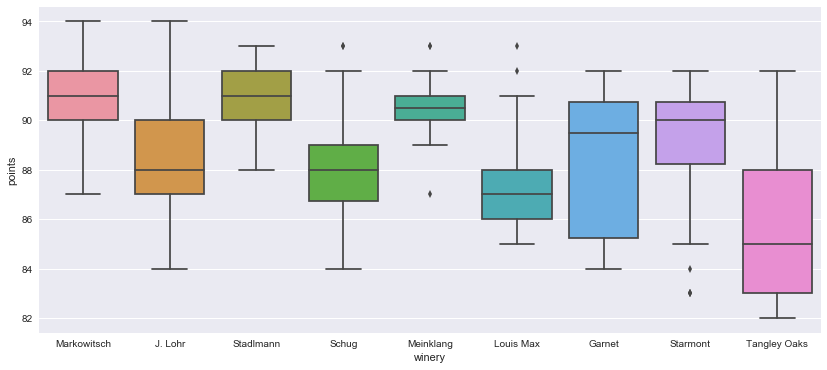

In [36]:
import seaborn as sns
sns.set_color_codes("pastel")
plt.style.use('seaborn')
plt.figure(figsize = (14,6))
sns.boxplot(
    x = 'winery',
    y = 'points',
    data = top_n
)

In [117]:
general_wine_points

,avg_points_general,winery_name
0,91.000000,Stadlmann
1,85.923077,Tangley_Oaks
2,88.807692,Starmont
3,87.958333,Schug
4,90.571429,Meinklang
5,90.619048,Markowitsch
6,88.300000,Garnet
7,88.397849,J. Lohr
8,87.500000,Louis Max


In [131]:
select = cheap_fruity_wine_pinotnoir.sort_values('points', ascending=False)[['winery','points']][1:11]
select = select.reset_index()
select1= select.iloc[1:]
select1=select1.rename(columns = {"points":"fruity_pinot_points"})

general_wine_points1= general_wine_points.rename(columns={"winery_name": "winery"})

general_wine_points1=general_wine_points1.sort_values('avg_points_general', ascending=False)

In [134]:
new=pd.merge(general_wine_points1.reset_index(),select1.reset_index(),on = 'winery')
new

,index_x,avg_points_general,winery,level_0,index_y,fruity_pinot_points
0,0,91.000000,Stadlmann,1,43930,93
1,5,90.619048,Markowitsch,6,35002,92
2,4,90.571429,Meinklang,5,99597,92
3,2,88.807692,Starmont,3,104066,92
4,7,88.397849,J. Lohr,8,94207,92
5,6,88.300000,Garnet,7,106901,92
6,3,87.958333,Schug,4,11094,92
7,8,87.500000,Louis Max,9,94850,91
